# Предсказание стоимости жилья

В проекте вам нужно обучить модель линейной регрессии на данных о жилье в Калифорнии в 1990 году. На основе данных нужно предсказать медианную стоимость дома в жилом массиве. Обучите модель и сделайте предсказания на тестовой выборке. Для оценки качества модели используйте метрики RMSE, MAE и R2.

Данные собраны в рамках переписи населения в США. Каждая строка содержит агрегированную статистику о жилом массиве. Жилой массив — минимальная географическая единица с населением от 600 до 3000 человек в зависимости от штата. Одна строка в данных содержит статистику в среднем о 1425.5 обитателях жилого массива.

В колонках датасета содержатся следующие данные:

- `longitude` — широта;
- `latitude` — долгота;
- `housing_median_age` — медианный возраст жителей жилого массива;
- `total_rooms` — общее количество комнат в домах жилого массива;
- `total_bedrooms` — общее количество спален в домах жилого массива;
- `population` — количество человек, которые проживают в жилом массиве;
- `households` — количество домовладений в жилом массиве;
- `median_income` — медианный доход жителей жилого массива;
- `median_house_value` — медианная стоимость дома в жилом массиве;
- `ocean_proximity` — близость к океану.

В большинстве колонок хранятся количественные данные, кроме одной — `ocean_proximity`. Она хранит категориальные значения.

## Подготовка данных

In [1]:
# загрузим необходимые библиотеки
import pandas as pd 
import numpy as np
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
import seaborn as sns
from pyspark.ml.feature import OneHotEncoder 
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml.regression import LinearRegression
from pyspark.ml.evaluation import RegressionEvaluator
RANDOM_SEED = 13

In [2]:
# инициализируем сессию и прочитаем данные с помощью pySpark
spark = SparkSession.builder \
                    .appName("EDA California Housing") \
                    .getOrCreate()
df_housing = spark.read.option('header', 'true').csv('/datasets/housing.csv', inferSchema = True) 
df_housing.printSchema() 

root
 |-- longitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- housing_median_age: double (nullable = true)
 |-- total_rooms: double (nullable = true)
 |-- total_bedrooms: double (nullable = true)
 |-- population: double (nullable = true)
 |-- households: double (nullable = true)
 |-- median_income: double (nullable = true)
 |-- median_house_value: double (nullable = true)
 |-- ocean_proximity: string (nullable = true)



<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Отлично, данные загружены:)</div>

In [3]:
# выведем названия колонок и их тип данных в виде таблицы
print(pd.DataFrame(df_housing.dtypes, columns=['column', 'type']))

               column    type
0           longitude  double
1            latitude  double
2  housing_median_age  double
3         total_rooms  double
4      total_bedrooms  double
5          population  double
6          households  double
7       median_income  double
8  median_house_value  double
9     ocean_proximity  string


In [4]:
# выведем базовые описательные статистики данных в виде таблицы в pandas
df_housing.describe().toPandas()

,summary,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,count,20640,20640,20640,20640,20433,20640,20640,20640,20640,20640
1,mean,-119.56970445736148,35.6318614341087,28.639486434108527,2635.7630813953488,537.8705525375618,1425.4767441860465,499.5396802325581,3.8706710029070246,206855.81690891474,None
2,stddev,2.003531723502584,2.135952397457101,12.58555761211163,2181.6152515827944,421.38507007403115,1132.46212176534,382.3297528316098,1.899821717945263,115395.61587441359,None
3,min,-124.35,32.54,1.0,2.0,1.0,3.0,1.0,0.4999,14999.0,<1H OCEAN
4,max,-114.31,41.95,52.0,39320.0,6445.0,35682.0,6082.0,15.0001,500001.0,NEAR OCEAN


В датасете более 20 тысяч строк. Максимальная медианная стоимость дома равна полумиллиону долларов.

In [5]:
# проверим, есть ли пропущенные значения в датасете, найдём их количество в каждой колонке.
columns = df_housing.columns

for column in columns:
    print(column, df_housing.where(F.isnan(column) | F.col(column).isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 207
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


`total_bedrooms` содержит всего `207` пропусков - чуть более одного процента от всех записей. Удалим строки, содержащие пропуски.

In [6]:
# удалим пропуски
df_housing = df_housing.na.drop(how='any')
columns = df_housing.columns
for column in columns:
    print(column, df_housing.where(F.isnan(column) | F.col(column).isNull()).count())

longitude 0
latitude 0
housing_median_age 0
total_rooms 0
total_bedrooms 0
population 0
households 0
median_income 0
median_house_value 0
ocean_proximity 0


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Хорошо, но можно заполнить, например вот так:

```python
    imputer = Imputer(inputCol='total_bedrooms', outputCol="out_total_bedrooms", strategy='median')
    model = imputer.fit(df)
    new_df = model.transform(df)
    
```


</div>

<div class="alert alert-info" style="border-radius: 13px; border: 1px solid lightgreen; padding: 13px; background-color: mintcream"> 
<b> Комментарий студента</b>
    
<span style="color:#008B8B"> Спасибо за совет =)</span>
    
</div>

In [7]:
# разделим колонки на числовые и текстовые
categorical_cols = ['ocean_proximity']
numerical_cols  = ["longitude", "latitude", "housing_median_age", "total_rooms",
                   "total_bedrooms", "population", "households", "median_income"]
target = "median_house_value" 

Трансформируем числовые и категориальные признаки.

In [8]:
# трансформируем категориальные признаки в числовое представление
# преобразуем колонку с категориальными значениями техникой One hot encoding
indexer = StringIndexer(inputCols=categorical_cols, 
                        outputCols=[c+'_idx' for c in categorical_cols]) 
df_housing = indexer.fit(df_housing).transform(df_housing)

ohe = OneHotEncoder(inputCols=[c+'_idx' for c in categorical_cols],
                        outputCols=[c+'_ohe' for c in categorical_cols])
df_housing = ohe.fit(df_housing).transform(df_housing)
df_housing.toPandas().head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity,ocean_proximity_idx,ocean_proximity_ohe
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY,3.0,"(0.0, 0.0, 0.0, 1.0)"


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Категориальные данные готовы:)

</div>

In [9]:
# объединим несколько столбцов признаков в векторный столбец
categorical_assembler = \
        VectorAssembler(inputCols=[c+'_ohe' for c in categorical_cols],
                                        outputCol="categorical_features")
df_housing = categorical_assembler.transform(df_housing)

In [10]:
# cтандартизируем числовые признаки, масштабируя их до единичной дисперсии
numerical_assembler = VectorAssembler(inputCols=numerical_cols, outputCol="numerical_features")
df_housing = numerical_assembler.transform(df_housing)
standardScaler = StandardScaler(inputCol='numerical_features',outputCol="numerical_features_scaled")
df_housing = standardScaler.fit(df_housing).transform(df_housing)

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> отмасштабировал корректно;)

</div>

In [11]:
# объединим числовые и категориальные признаки в векторный столбец
all_features = ['categorical_features','numerical_features_scaled']
final_assembler = VectorAssembler(inputCols=all_features, outputCol="features") 
df_housing = final_assembler.transform(df_housing)
df_housing.select(all_features).show(3)

+--------------------+-------------------------+
|categorical_features|numerical_features_scaled|
+--------------------+-------------------------+
|       (4,[3],[1.0])|     [-61.005863841998...|
|       (4,[3],[1.0])|     [-61.000872770752...|
|       (4,[3],[1.0])|     [-61.010854913244...|
+--------------------+-------------------------+
only showing top 3 rows



Данные готовы к обучению моделей.

## Обучение моделей

Построим две модели линейной регрессии на разных наборах данных:
* используя все данные из файла;
* используя только числовые переменные, исключив категориальные.  

Для построения модели используем оценщик `LinearRegression`.

In [12]:
# разделим данные на две части
train_data, test_data = df_housing.randomSplit([.75,.25], seed=RANDOM_SEED)
print(train_data.count(), test_data.count())

15459 4974


In [13]:
# обучим модель линейной регрессии на всех данных
lr_1 = LinearRegression(labelCol=target, featuresCol='features',regParam=0.0)
model = lr_1.fit(train_data)
predictions = model.transform(test_data)
predictions_col = 'prediction'

22/09/09 11:15:53 WARN Instrumentation: [ec2e1d66] regParam is zero, which might cause numerical instability and overfitting.
22/09/09 11:15:54 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/09/09 11:15:54 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/09/09 11:15:54 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/09/09 11:15:54 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


In [14]:
# обучим модель линейной регрессии на числовых переменных
lr_2 = LinearRegression(labelCol=target, featuresCol='numerical_features_scaled', regParam=0.0)
model2 = lr_2.fit(train_data)
predictions2 = model2.transform(test_data)

22/09/09 11:15:56 WARN Instrumentation: [6370e485] regParam is zero, which might cause numerical instability and overfitting.


<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Огонь! Все верно обучил

</div>

## Анализ результатов

Сравним результаты работы линейной регрессии на двух наборах данных по метрикам `RMSE`, `MAE` и `R2`.

In [15]:
# используем оценщик регрессии для анализа полученных предсказаний двух моделей
evaluator = RegressionEvaluator(predictionCol=predictions_col, labelCol = target)

In [16]:
# расчитаем метрику RMSE для кaждой из моделей
print('model1:', evaluator.evaluate(predictions, {evaluator.metricName: "rmse"}))
print('model2:', evaluator.evaluate(predictions2, {evaluator.metricName: "rmse"}))

model1: 67977.46572443032
model2: 68759.52956542479


Согласно метрики `RMSE`, модель на всех данных работает точнее.

In [17]:
# расчитаем метрику MAE для кaждой из моделей
print('model1:', evaluator.evaluate(predictions, {evaluator.metricName: "mae"}))
print('model2:', evaluator.evaluate(predictions2, {evaluator.metricName: "mae"}))

model1: 49309.34233482486
model2: 50250.84061468822


Согласно метрики `MAE`, модель на всех данных работает точнее.

In [18]:
# расчитаем метрику R2 для кaждой из моделей
print('model1:', evaluator.evaluate(predictions, {evaluator.metricName: "r2"}))
print('model2:', evaluator.evaluate(predictions2, {evaluator.metricName: "r2"}))

model1: 0.6500518895579303
model2: 0.6419534386731541


Согласно метрики `R2`, модель на всех данных работает точнее.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Протестировал абсолютно корректно;)

</div>

**Вывод**  

Сравнили две модели линейной регрессии, обученные на двух наборах данных (используя все данные и только числовые переменные) по метрикам `RMSE`, `MAE` и `R2` .  
Cогласно всем трём метрикам, точнее работает модель, использующая все данные из файла.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Немного полезного материала:

Немного полезной информации:
+  https://www.tutorialspoint.com/pyspark/index.htm
+  https://www.guru99.com/pyspark-tutorial.html
+  https://databricks.com/spark/getting-started-with-apache-spark/machine-learning#load-sample-data


</div>

<div class="alert alert-info" style="border-radius: 13px; border: 1px solid lightgreen; padding: 13px; background-color: mintcream"> 
<b> Комментарий студента</b>
    
<span style="color:#008B8B"> Спасибо за полезные ссылки, добавлю в свою библиотеку =)</span>
    
</div>

<font color='blue'><b>Итоговый комментарий ревьюера</b></font>
<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>Алексей, спасибо за хороший проект!!! Я готов принять работу, но хочу убедиться, что тебе все понятно.<br>
Если есть какие либо вопросы я с удовольствием на них отвечу:)</div>


<div class="alert alert-info" style="border-radius: 13px; border: 1px solid lightgreen; padding: 13px; background-color: mintcream"> 
<b> Комментарий студента</b>
    
<span style="color:#008B8B"> Большое спасибо! Вопросов нет =)</span>
    
</div>

<div class="alert alert-success">
<b>Комментарий ревьюера V2✔️:</b> Отлично:) Удачи в следующих проектах!!!
    
    

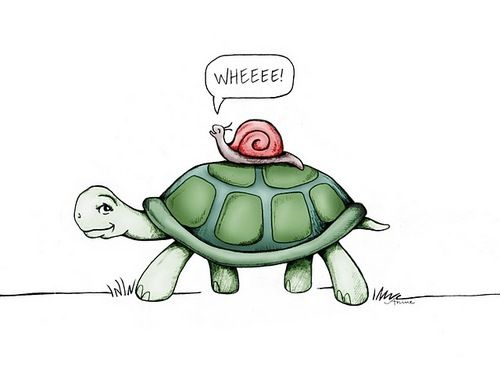


</div>